# Exercise 3 - Mean Absolute Error

In class you learned about RNNs and LSTMs for prediction, as well as a simple methodology to pick a decent learning rate for the stochastic gradient descent optimizer. In this exercise you’ll take a synthetic data set and write the code to pick the learning rate and then train on it to get an MAE of < 3

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

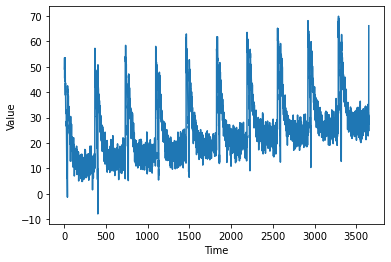

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 14ms/step - loss: 11.5241 - mae: 12.0219
Epoch 2/100
94/94 [==============================] - 1s 14ms/step - loss: 8.4712 - mae: 8.9592
Epoch 3/100
94/94 [==============================] - 1s 14ms/step - loss: 6.6281 - mae: 7.1045
Epoch 4/100
94/94 [==============================] - 1s 14ms/step - loss: 5.9220 - mae: 6.3992
Epoch 5/100
94/94 [==============================] - 1s 14ms/step - loss: 5.7045 - mae: 6.1804
Epoch 6/100
94/94 [==============================] - 1s 15ms/step - loss: 5.6354 - mae: 6.1083
Epoch 7/100
94/94 [==============================] - 1s 15ms/step - loss: 5.6035 - mae: 6.0757
Epoch 8/100
94/94 [==============================] - 1s 14ms/step - loss: 5.5791 - mae: 6.0518
Epoch 9/100
94/94 [==============================] - 1s 15ms/step - loss: 5.5573 - mae: 6.0285
Epoch 10/100
94/94 [==============================] - 1s 14ms/step - loss: 5.5343 - mae: 6.0055
Epoch 11/100
94/94 [===========================

(1e-08, 0.0001, 0.0, 30.0)

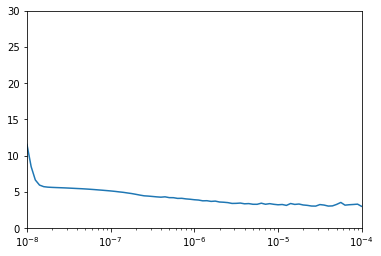

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
# FROM THIS PICK A LEARNING RATE

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=450,verbose=1)                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/450
94/94 [==============================] - 1s 14ms/step - loss: 88.8053 - mae: 6.1791
Epoch 2/450
94/94 [==============================] - 1s 14ms/step - loss: 45.5590 - mae: 4.4234
Epoch 3/450
94/94 [==============================] - 1s 14ms/step - loss: 32.5304 - mae: 3.6865
Epoch 4/450
94/94 [==============================] - 1s 14ms/step - loss: 32.9239 - mae: 3.8137
Epoch 5/450
94/94 [==============================] - 1s 14ms/step - loss: 31.3498 - mae: 3.7998
Epoch 6/450
94/94 [==============================] - 1s 14ms/step - loss: 27.4639 - mae: 3.4305
Epoch 7/450
94/94 [==============================] - 1s 14ms/step - loss: 25.8405 - mae: 3.3237
Epoch 8/450
94/94 [==============================] - 1s 14ms/step - loss: 27.1647 - mae: 3.4872
Epoch 9/450
94/94 [==============================] - 1s 14ms/step - loss: 25.4382 - mae: 3.3392
Epoch 10/450
94/94 [==============================] - 1s 15ms/step - loss: 25.2603 - mae: 3.3103
Epoch 11/450
94/94 [===================

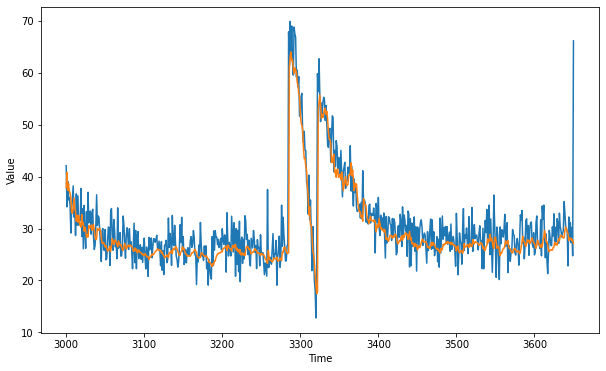

In [16]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

2.94057

<Figure size 432x288 with 0 Axes>

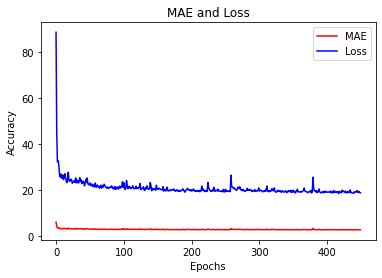

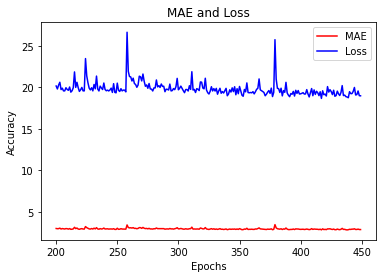

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()